<a href="https://colab.research.google.com/github/alsnhll/SEIR_COVID19/blob/master/SEIR_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Authors
The original SEIR model and ipython notebook for it were developed by Dr. Alison Hill
and cloned from github at
https://github.com/alsnhll/SEIR_COVID19
referenced on the web from the 50 best modelling apps for covid: 
https://towardsdatascience.com/top-5-r-resources-on-covid-19-coronavirus-1d4c8df6d85f

The cautionary feedback version of the model was conceived and written by John S McCaskill, a fellow of the European Centre for Living Technology. It is based on experience in modelling Q$\beta$ quasispecies viral infections of bacterial cells back in the late 80's and early 90's in Manfred Eigen's lab at the Max Planck Institute. In cell free model systems, exponential growth of the virus changes to linear growth because of the limited amount of replicase enzyme available. I was curious to see if the often remarkably linear response following an early exponential growth (or power law in the case of small world connectivity network) phase, could be simply accounted for by a cautionary saturation effect as outlined below.

## SEIR and SCEIR Models

### Equations

\begin{equation}
\begin{split}
\dot{S} &= -(\beta_1 I_1 +\beta_2 I_2 + \beta_3 I_3) S + c_1 S_c - c_2*S*I_3\\
\dot{S_c} &= - c_0(\beta_1 I_1 +\beta_2 I_2 + \beta_3 I_3) S_c - c_1 S_c + c_2*S*I_3\\
\dot{E} &=(\beta_1 I_1 +\beta_2 I_2 + \beta_3 I_3 ) (S + c_0 S_c) - a E \\
\dot{I_1} &= a E - \gamma_1 I_1 - p_1 I_1 \\
\dot{I_2} &= p_1 I_1 -\gamma_2 I_2 - p_2 I_2 \\
\dot{I_3} & = p_2 I_2 -\gamma_3 I_3 - \mu I_3 \\
\dot{R} & = \gamma_1 I_1 + \gamma_2 I_2 + \gamma_3 I_3 \\
\dot{D} & = \mu I_3
\end{split}
\end{equation}

The use of I_3 as a state variable triggering susceptibles to execute caution is just one choice. In contrast with deaths, it does not accumulate over time and so retains the property of an active threat to society, rather than an historical one.

Actually, the effect of caution may be quadratic, since both the individual doing the infection and individual potentially being infected may be executing caution. The current version assumes that infectives do not change their precautionary measures in response to I_3. To implement this we would need to further distinguish careful and non careful infectives at least up to the I_1 level.

### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $E$: Exposed individuals - infected but not yet infectious or symptomatic
* $I_i$: Infected individuals in severity class $i$. Severity increaes with $i$ and we assume individuals must pass through all previous classes
  * $I_1$: Mild infection (hospitalization not required)
  * $I_2$: Severe infection (hospitalization required)
  * $I_3$: Critical infection (ICU required)
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+E+I_1+I_2+I_3+R+D$ Total population size (constant)

### Parameters
* $\beta_i$ rate at which infected individuals in class $I_i$ contact susceptibles and infect them
* $a$ rate of progression from the exposed to infected class
* $\gamma_i$ rate at which infected individuals in class $I_i$ recover from disease and become immune
* $p_i$ rate at which infected individuals in class $I_i$ progress to class $I_{I+1}$
* $\mu$ death rate for individuals in the most severe stage of disease

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible


### Basic reproductive ratio

$R_0$ in the simple uncautioned SEI3R model is the sum of 
1. the average number of secondary infections generated from an individual in stage $I_1$
2. the probability that an infected individual progresses to $I_2$ multiplied by the average number of secondary infections generated from an individual in stage $I_2$
3.  the probability that an infected individual progresses to $I_3$ multiplied by the average number of secondary infections generated from an individual in stage $I_3$

\begin{equation}
\begin{split}
R_0 & = N\frac{\beta_1}{p_1+\gamma_1} + \frac{p_1}{p_1 + \gamma_1} \left( \frac{N \beta_2}{p_2+\gamma_2} + \frac{p_2}{p_2 + \gamma_2} \frac{N \beta_3}{\mu+\gamma_3}\right)\\
&= N\frac{\beta_1}{p_1+\gamma_1} \left(1 + \frac{p_1}{p_2 + \gamma_2}\frac{\beta_2}{\beta_1} \left( 1 + \frac{p_2}{\mu + \gamma_3} \frac{\beta_3}{\beta_2} \right) \right)
\end{split}
\end{equation}

$R_0$ as such clearly applies to a population where S=N, i.e. at outset of infection.
As such, it remains unchanged in the SCEI3R model, since S_c is then 0.

###  Influence of caution on SEIR model

In [1]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
#Defining the differential equations

#Don't track S because all variables must add up to 1 
#include blank first entry in vector for beta, gamma, p so that indices align in equations and code. 
#In the future could include recovery or infection from the exposed class (asymptomatics)

def seir(y,t,b,a,g,p,u,N): 
    dy=[0,0,0,0,0,0]
    S=N-sum(y);
    dy[0]=np.dot(b[1:3],y[1:3])*S-a*y[0] # E
    dy[1]= a*y[0]-(g[1]+p[1])*y[1] #I1
    dy[2]= p[1]*y[1] -(g[2]+p[2])*y[2] #I2
    dy[3]= p[2]*y[2] -(g[3]+u)*y[3] #I3
    dy[4]= np.dot(g[1:3],y[1:3]) #R
    dy[5]=u*y[3] #D

    return dy

#include caution correction via y[6]=S_c and three parameters in vector c (see below)

def sceir(y,t,b,a,g,p,u,c,N): 
    dy=[0,0,0,0,0,0,0]
    S=N-sum(y);
    dy[0]=np.dot(b[1:3],y[1:3])*(S+c[0]*y[6])-a*y[0] # E
    dy[1]= a*y[0]-(g[1]+p[1])*y[1] #I1
    dy[2]= p[1]*y[1] -(g[2]+p[2])*y[2] #I2
    dy[3]= p[2]*y[2] -(g[3]+u)*y[3] #I3
    dy[4]= np.dot(g[1:3],y[1:3]) #R
    dy[5]=u*y[3] #D
    dy[6]= -c[0]*np.dot(b[1:3],y[1:3])*y[6]-c[1]*y[6]+c[2]*S*y[3]  #Sc

    return dy

In [3]:
# Define parameters based on clinical observations

# Dr. Alison will add data sources soon
# https://github.com/midas-network/COVID-19/tree/master/parameter_estimates/2019_novel_coronavirus

Exposure=0.25 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=10 #Duration of mild infections, days
FracMild=0.8  #Fraction of infections that are mild
FracSevere=0.15 #Fraction of infections that are severe
FracCritical=0.05 #Fraction of infections that are critical
CFR=0.02 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=7 #Time from ICU admission to death, days
DurHosp=11 #Duration of hospitalization, days

# Model extension by John McCaskill to include caution 
CautionFactor= 0.3 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 14. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.25 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

In [4]:
# Define parameters and run ODE

N=1000000
b=np.zeros(4) #beta
g=np.zeros(4) #gamma
p=np.zeros(3)
c=np.zeros(3) #caution

a=1/IncubPeriod

u=(1/TimeICUDeath)*(CFR/FracCritical)
g[3]=(1/TimeICUDeath)-u

p[2]=(1/DurHosp)*(FracCritical/(FracCritical+FracSevere))
g[2]=(1/DurHosp)-p[2]

g[1]=(1/DurMildInf)*FracMild
p[1]=(1/DurMildInf)-g[1]

c[0]=CautionFactor
c[1]=1/CautionRetention
c[2]=1/(N*ICUFrac*CautionICUFrac)

#b=Exposure*np.ones(4)/N # all stages transmit equally
b=Exposure*np.array([0,1,0,0])/N # hospitalized cases don't transmit

#Calculate basic reproductive ratio
R0=N*((b[1]/(p[1]+g[1]))+(p[1]/(p[1]+g[1]))*(b[2]/(p[2]+g[2])+ (p[2]/(p[2]+g[2]))*(b[3]/(u+g[3]))))
print("R0 = {0:4.1f}".format(R0))

R0 =  2.5


In [5]:
print(b)
print(a)
print(g)
print(p)
print(u)
print(c)

[0.0e+00 2.5e-07 0.0e+00 0.0e+00]
0.2
[0.         0.08       0.06818182 0.08571429]
[0.         0.02       0.02272727]
0.057142857142857134
[0.3        0.07142857 0.004     ]


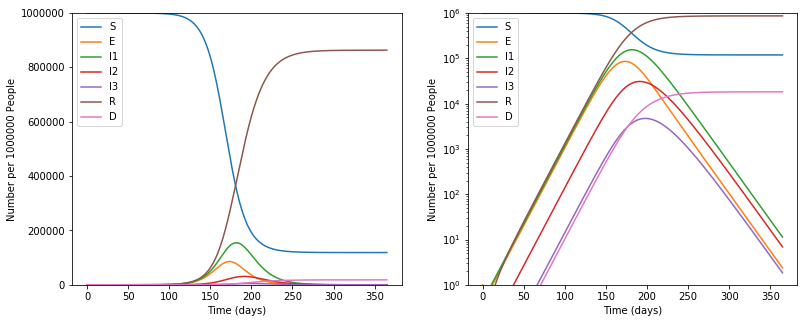

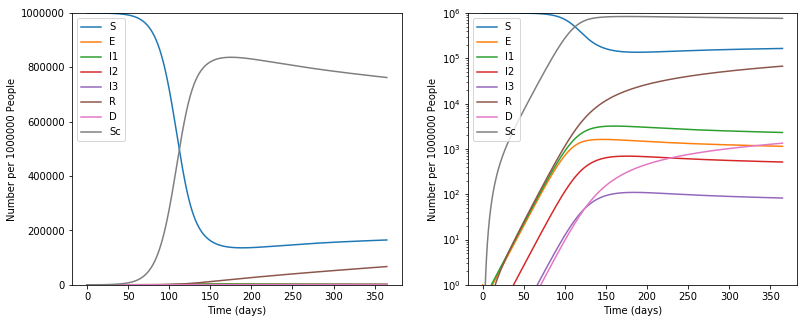

In [6]:
tmax=365
tvec=np.arange(0,tmax,0.1)

#SEIR
ic=np.zeros(6)
ic[0]=1
soln=odeint(seir,ic,tvec,args=(b,a,g,p,u,N))
soln=np.hstack((N-np.sum(soln,axis=1,keepdims=True),soln))

#Plot on linear scale
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,soln)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000000 People")
plt.legend(("S","E","I1","I2","I3","R","D"))
plt.ylim([0,1000000])

#Same plot but on log scale
plt.subplot(1,2,2)
plt.plot(tvec,soln)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000000 People")
plt.legend(("S","E","I1","I2","I3","R","D"))
plt.ylim([1,1000000])
#plt.tight_layout()

#SCEIR
icc=np.zeros(7)
icc[0]=1
solnc=odeint(sceir,icc,tvec,args=(b,a,g,p,u,c,N))
solnc=np.hstack((N-np.sum(solnc,axis=1,keepdims=True),solnc))

#Plot on linear scale
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,solnc)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000000 People")
plt.legend(("S","E","I1","I2","I3","R","D","Sc"))
plt.ylim([0,1000000])

#Same plot but on log scale
plt.subplot(1,2,2)
plt.plot(tvec,solnc)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000000 People")
plt.legend(("S","E","I1","I2","I3","R","D","Sc"))
plt.ylim([1,1000000])
#plt.tight_layout()
print("")

#### Cumulative corona cases

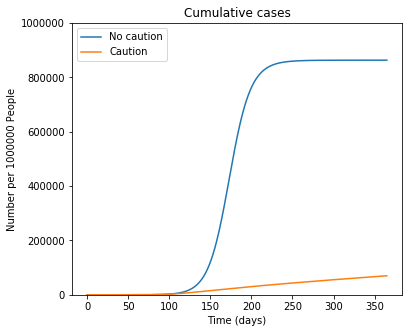

In [7]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,np.sum(soln[:,2:6],axis=1,keepdims=True))
plt.plot(tvec,np.sum(solnc[:,2:6],axis=1,keepdims=True))
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000000 People")
plt.legend(("No caution","Caution"))
plt.ylim([0,1000000])
plt.title('Cumulative cases')
print("")

## SCCEIR model with caution distinguished $E$ and  𝐼1

### Equations

\begin{equation}
\begin{split}
\dot{S} &= -(\beta_1 (I_1 + c_0 I_{1c}) +\beta_2 I_2 + \beta_3 I_3) S + c_1 S_c - c_2*S*I_3\\
\dot{S_c} &= - c_0(\beta_1 (I_1 + c_0 I_{1c}) +\beta_2 I_2 + \beta_3 I_3) S_c - c_1 S_c + c_2*S*I_3\\
\dot{E} &=(\beta_1 (I_1 + c_0 I_{1c}) +\beta_2 I_2 + \beta_3 I_3 ) S - a E \\
\dot{E_c} &=(\beta_1 (I_1 + c_0 I_{1c}) +\beta_2 I_2 + \beta_3 I_3 ) c_0 S_c - a E \\
\dot{I_1} &= a E - \gamma_1 I_1 - p_1 I_1 \\
\dot{I_{1c}} &= a E_c - \gamma_1 I_{1c} - p_1 I_{1c} \\
\dot{I_2} &= p_1 (I_1 + I_{1c}) -\gamma_2 I_2 - p_2 I_2 \\
\dot{I_3} & = p_2 I_2 -\gamma_3 I_3 - \mu I_3 \\
\dot{R} & = \gamma_1 (I_1 + I_{1c}) + \gamma_2 I_2 + \gamma_3 I_3 \\
\dot{D} & = \mu I_3
\end{split}
\end{equation}

The use of I_3 as a state variable triggering susceptibles to execute caution is just one choice. In contrast with deaths, it does not accumulate over time and so retains the property of an active threat to society, rather than an historical one.

Here, the effect of caution is quadratic, since both the individual doing the infection and individual potentially being infected may be executing caution. To implement this we distinguish careful and non careful exposed and infectives up to the I_1 level. Once in hospital there is no difference, since all caution is executed wrt infected patients.

### Variables
* $S$: Susceptible individuals living as normal
* $S_c$: Susceptible individuals exercising pandemy precautions
* $E$: Exposed individuals living as normal - infected but not yet infectious or symptomatic
* $E_c$: Exposed individuals exercising pandemy precautions
* $I_i$: Infected individuals in severity class $i$. Severity increaes with $i$ and we assume individuals must pass through all previous classes. Split non hospital cases by caution.
  * $I_1$: Mild infection (hospitalization not required), living as normal
  * $I_{1c}$: Mild infection (hospitalization not required), exercising caution
  * $I_2$: Severe infection (hospitalization required)
  * $I_3$: Critical infection (ICU required)
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+S_c+E+E_c+I_{1c}+I_1+I_2+I_3+R+D$ Total population size (constant)

### Parameters
* $\beta_i$ rate at which infected individuals in class $I_i$ contact susceptibles and infect them
* $a$ rate of progression from the exposed to infected class
* $\gamma_i$ rate at which infected individuals in class $I_i$ recover from disease and become immune
* $p_i$ rate at which infected individuals in class $I_i$ progress to class $I_{I+1}$
* $\mu$ death rate for individuals in the most severe stage of disease

* $c_i$ three parameters characterizing cautionary response of population via class $S_c$

    - c_0 : reduction factor for exposure for cautioned susceptibles

    - c_1 : duration of caution (exponential decay time constant in days)

    - c_2 : rate constant for transition from uncautioned to cautioned susceptible

###  Influence of caution on SCCEIR model

In [8]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import odeint

In [9]:
#Defining the differential equations

#Don't track S because all variables must add up to 1 
#include blank first entry in vector for beta, gamma, p so that indices align in equations and code. 
def seir(y,t,b,a,g,p,u,N): 
    dy=[0,0,0,0,0,0]
    S=N-sum(y);
    dy[0]=np.dot(b[1:3],y[1:3])*S-a*y[0] # E
    dy[1]= a*y[0]-(g[1]+p[1])*y[1] #I1
    dy[2]= p[1]*y[1] -(g[2]+p[2])*y[2] #I2
    dy[3]= p[2]*y[2] -(g[3]+u)*y[3] #I3
    dy[4]= np.dot(g[1:3],y[1:3]) #R
    dy[5]=u*y[3] #D

    return dy
#include caution correction via y[6]=S_c and three parameters in vector c (see below)
def sceir(y,t,b,a,g,p,u,c,N): 
    dy=[0,0,0,0,0,0,0]
    S=N-sum(y);
    dy[0]=np.dot(b[1:3],y[1:3])*(S+c[0]*y[6])-a*y[0] # E
    dy[1]= a*y[0]-(g[1]+p[1])*y[1] #I1
    dy[2]= p[1]*y[1] -(g[2]+p[2])*y[2] #I2
    dy[3]= p[2]*y[2] -(g[3]+u)*y[3] #I3
    dy[4]= np.dot(g[1:3],y[1:3]) #R
    dy[5]=u*y[3] #D
    dy[6]= -c[0]*np.dot(b[1:3],y[1:3])*y[6]-c[1]*y[6]+c[2]*S*y[3]  #Sc
    return dy

#include caution correction to E and I_1 via y[7]=E_c and y[8]=I_1c
def scceir(y,t,b,a,g,p,u,c,N): 
    dy=[0,0,0,0,0,0,0,0,0]
    S=N-sum(y);
    dy[0]=np.dot(b[1:3],y[1:3])*S+c[0]*b[1]*y[8]*S-a*y[0] # E
    dy[1]= a*y[0]-(g[1]+p[1])*y[1] #I1
    dy[2]= p[1]*(y[1]+y[8])-(g[2]+p[2])*y[2] #I2
    dy[3]= p[2]*y[2] -(g[3]+u)*y[3] #I3
    dy[4]= np.dot(g[1:3],y[1:3])+g[1]*y[8] #R
    dy[5]=u*y[3] #D
    dy[6]= -c[0]*np.dot(b[1:3],y[1:3])*y[6]-c[0]*c[0]*b[1]*y[8]*y[6]-c[1]*y[6]+c[2]*S*y[3]  #Sc
    dy[7]=np.dot(b[1:3],y[1:3])*c[0]*y[6]+c[0]*c[0]*b[1]*y[8]*y[6]-a*y[7] # Ec
    dy[8]= a*y[7]-(g[1]+p[1])*y[8] #I1
    return dy

In [10]:
# Define parameters based on clinical observations

# Dr. Alison will add data sources soon
# https://github.com/midas-network/COVID-19/tree/master/parameter_estimates/2019_novel_coronavirus

Exposure=0.25 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days 
DurMildInf=10 #Duration of mild infections, days
FracMild=0.8  #Fraction of infections that are mild
FracSevere=0.15 #Fraction of infections that are severe
FracCritical=0.05 #Fraction of infections that are critical
CFR=0.02 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=7 #Time from ICU admission to death, days
DurHosp=11 #Duration of hospitalization, days

# Model extension by John McCaskill to include caution 
CautionFactor= 0.3 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 14. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.25 # Fraction of ICUs occupied leading to 90% of susceptibles in caution 
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

In [11]:
# Define parameters and run ODE
tmax = 365
N=1000000
b=np.zeros(4) #beta
g=np.zeros(4) #gamma
p=np.zeros(3) # progression
c=np.zeros(3) #caution

a=1/IncubPeriod

u=(1/TimeICUDeath)*(CFR/FracCritical)
g[3]=(1/TimeICUDeath)-u

p[2]=(1/DurHosp)*(FracCritical/(FracCritical+FracSevere))
g[2]=(1/DurHosp)-p[2]

g[1]=(1/DurMildInf)*FracMild
p[1]=(1/DurMildInf)-g[1]

c[0]=CautionFactor
c[1]=1/CautionRetention
c[2]=1/(N*ICUFrac*CautionICUFrac)   # this is the rate coefficient giving 1/day at IE = denom

#b=Exposure*np.ones(4)/N # all stages transmit equally
b=Exposure*np.array([0,1,0,0])/N # hospitalized cases don't transmit

#Calculate basic reproductive ratio
R0=N*((b[1]/(p[1]+g[1]))+(p[1]/(p[1]+g[1]))*(b[2]/(p[2]+g[2])+ (p[2]/(p[2]+g[2]))*(b[3]/(u+g[3]))))
print("R0 = {0:4.1f}".format(R0))

R0 =  2.5


In [54]:
# Jupyter Specifics
from IPython.display import HTML
from ipywidgets.widgets import interact, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed

style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [57]:
def solveplot(b,a,g,p,u,c,N,tmax,scale='linear',species='no_susc',plottitle= '',
              label='',newplot = True,models=['SEIR','SCEIR','SCCEIR']):
    """
    b,a,g,p,u,c,N,tmax  simulation parameters
    scale: alternaticve 'linear' or 'log'
    species alternatives 'all', 'confirmed', 'deaths', 'daily confirmed'
    title
    newplot : whether to open new plot True/False
    """
    tvec=np.arange(0,tmax,0.1)
    nmodels = len(models)
    nm = 0
    
    if newplot == True:
        plt.figure(figsize=(nmodels*8,6))

    solns = []    
    if 'SEIR' in models:   #SEIR
        nm = nm + 1
        ic=np.zeros(6)
        ic[0]=1
        soln=odeint(seir,ic,tvec,args=(b,a,g,p,u,N))
        soln=np.hstack((N-np.sum(soln,axis=1,keepdims=True),soln)) # adds S as first elt

        #Plot
        plt.subplot(1,nmodels,nm)
        if scale == 'log': #Plot on log scale
            plt.semilogy()
            plt.ylim([1,10000])
        elif species != 'daily confirmed':           # Plot on normal linear scale
            #plt.ylim([0,10000])
            pass
        if species == 'no_susc':
            plt.plot(tvec,soln[:,1:5],label=label)
            plt.legend(("E","I1","I2","I3"))
        elif species == 'confirmed' or species == 'daily confirmed':
            suma = np.sum(soln[:,2:7],axis=1)
            # print('length=',len(suma))
            if species == 'daily confirmed':
                sumd = np.zeros(len(suma))
                for i in range(1,len(suma)):
                    sumd[i] = suma[i]-suma[i-1]
                #plt.ylim([0,1000])
                plt.plot(tvec,sumd,label=label)
            else:
                #plt.ylim([0,200000])
                plt.plot(tvec,suma,label=label)
        else:
            plt.plot(tvec,soln,label=label)
            plt.legend(("S","E","I1","I2","I3","R","D"))
        plt.xlabel("Time (days)")
        plt.ylabel("Number per 1000000 People")
        plt.title('SEIR %s' % plottitle)
        solns.append(soln)
    
    if 'SCEIR' in models:   #SCEIR
        nm = nm + 1
        ic=np.zeros(7)
        ic[0]=1
        solnc=odeint(sceir,ic,tvec,args=(b,a,g,p,u,c,N))
        solnc=np.hstack((N-np.sum(solnc,axis=1,keepdims=True),solnc)) # adds S as first elt

        #Plot
        plt.subplot(1,nmodels,nm)
        if scale == 'log': #Plot on log scale
            plt.semilogy()
            plt.ylim([1,10000])
        elif species != 'daily confirmed':           # Plot on normal linear scale
            #plt.ylim([0,10000])
            pass
        if species == 'no_susc':
            plt.plot(tvec,solnc[:,1:5],label=label)
            plt.legend(("E","I1","I2","I3"))
        elif species == 'confirmed' or species == 'daily confirmed':
            suma = np.sum(solnc[:,2:7],axis=1)
            # print('length=',len(suma))
            if species == 'daily confirmed':
                sumd = np.zeros(len(suma))
                for i in range(1,len(suma)):
                    sumd[i] = suma[i]-suma[i-1]
                #plt.ylim([0,1000])
                plt.plot(tvec,sumd,label=label)
            else:
                #plt.ylim([0,200000])
                plt.plot(tvec,suma,label=label)
        else:
            plt.plot(tvec,solnc,label=label)
            plt.legend(("S","E","I1","I2","I3","R","D","Sc"))
        plt.xlabel("Time (days)")
        plt.ylabel("Number per 1000000 People")
        plt.title('SCEIR %s' % plottitle)
        solns.append(solnc)

    if 'SCCEIR' in models:   #SCCEIR
        nm = nm + 1
        ic=np.zeros(9)
        ic[0]=1
        solncc=odeint(scceir,ic,tvec,args=(b,a,g,p,u,c,N))
        solncc=np.hstack((N-np.sum(solncc,axis=1,keepdims=True),solncc)) # prepend S

        #Plot
        plt.subplot(1,nmodels,nm)
        if scale == 'log': #Plot on log scale
            plt.semilogy()
            plt.ylim([1,10000])
        elif species != 'daily confirmed':           # Plot on normal linear scale
            #plt.ylim([0,10000])
            pass
        if species == 'no_susc':
            plt.plot(tvec,solncc[:,1:5])
            plt.legend(("E","I1","I2","I3"))
        elif species == 'confirmed' or species == 'daily confirmed':
            suma = np.sum(solncc[:,2:7],axis=1) + solncc[:,9]
            if species == 'daily confirmed':
                sumd = np.zeros(len(suma))
                for i in range(1,len(suma)):
                    sumd[i] = suma[i]-suma[i-1]
                # plt.ylim([0,1000])
                plt.plot(tvec,sumd,label=label)
            else:
                # plt.ylim([0,200000])
                plt.plot(tvec,suma,label=label)
        else:
            plt.plot(tvec,solncc,label=label)
            plt.legend(("S","E","I1","I2","I3","R","D","Sc","Ec","I1c"))
        plt.xlabel("Time (days)")
        plt.ylabel("Number per 1000000 People")
        plt.title('SCCEIR %s' % plottitle)
        solns.append(solncc)
    return solns
        

In [17]:
(b,a,g,p,u,c,N,tmax)

(array([0.0e+00, 2.5e-07, 0.0e+00, 0.0e+00]),
 0.2,
 array([0.        , 0.08      , 0.06818182, 0.08571429]),
 array([0.        , 0.02      , 0.02272727]),
 0.057142857142857134,
 array([0.3       , 0.07142857, 0.004     ]),
 1000000,
 365)

In [21]:
aa = FloatSlider(min=0,max=1,step=0.01,value=a,description='a',style=style,layout=slider_layout)


In [22]:
aa

FloatSlider(value=0.2, description='a', layout=Layout(width='99%'), max=1.0, step=0.01, style=SliderStyle(desc…

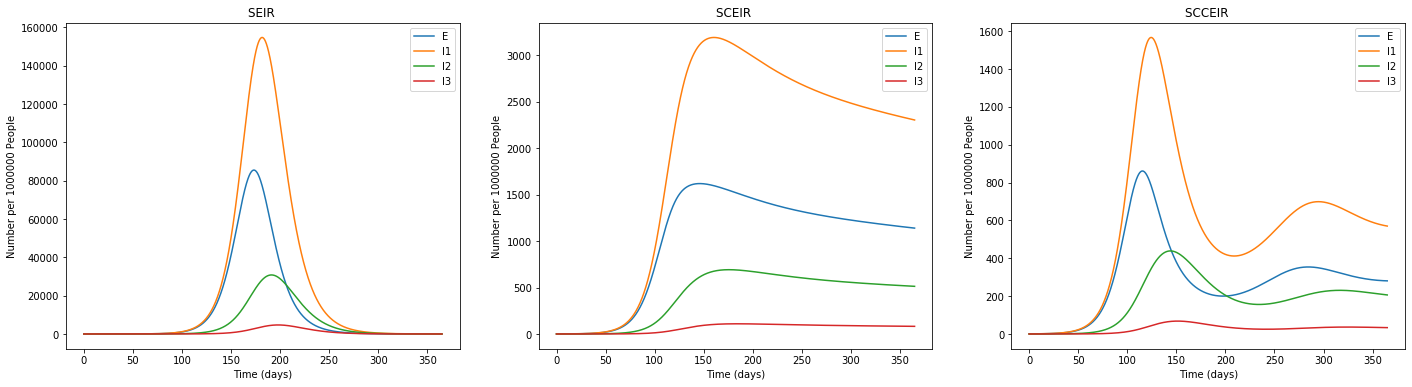

In [29]:
solveplot(b=b,a=a,g=g,p=p,u=u,c=c,N=N,tmax=tmax,scale='linear');

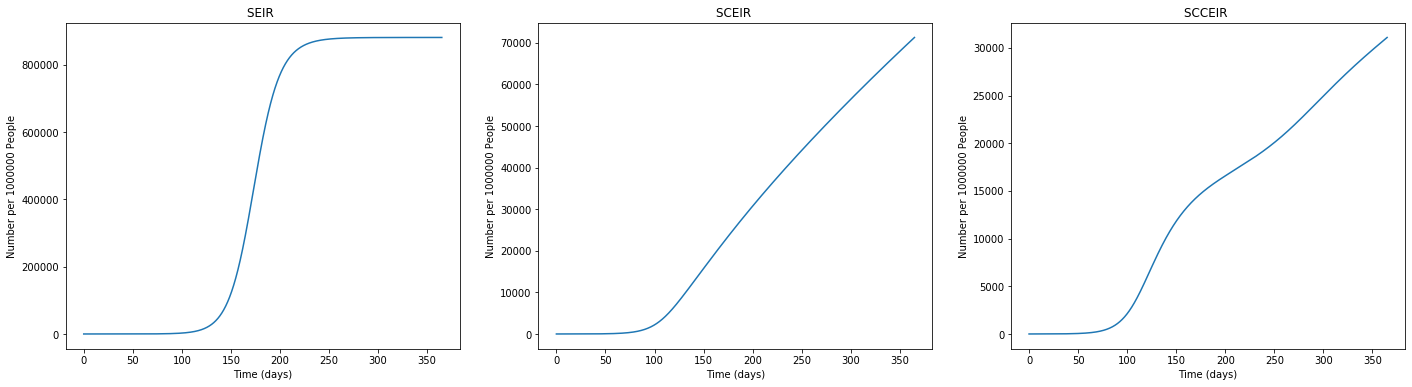

In [15]:
solns=solveplot(b,a,g,p,u,c,N,tmax,scale='linear',species='confirmed')

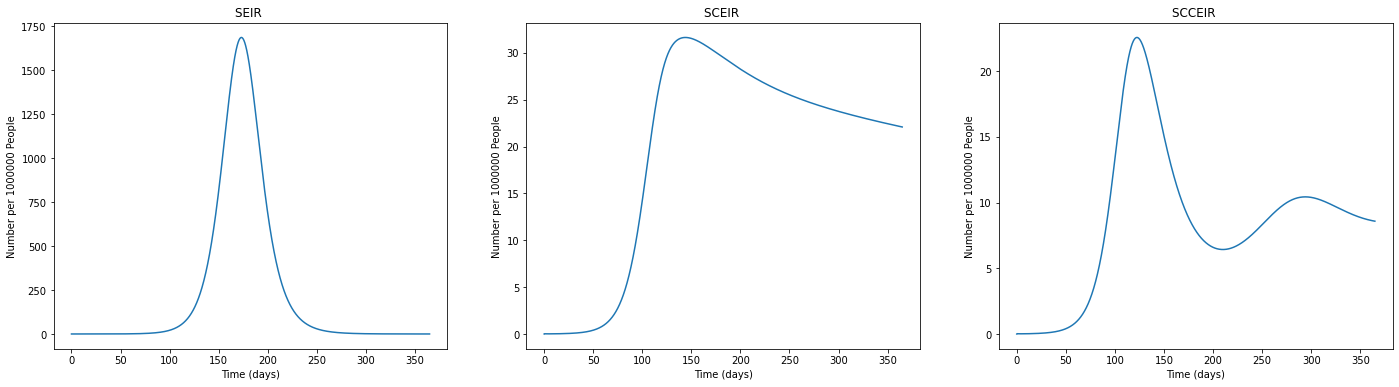

In [15]:
solns=solveplot(b,a,g,p,u,c,N,tmax,scale='linear',species='daily confirmed')

/Users/n/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel/__main__.py:63: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/n/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel/__main__.py:101: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


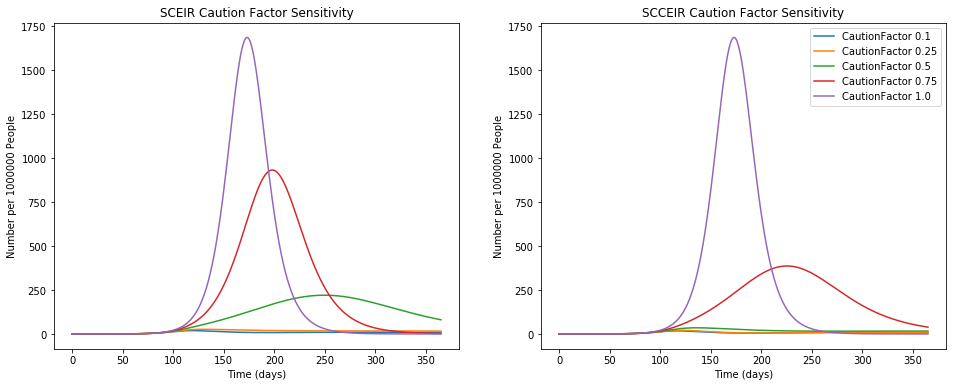

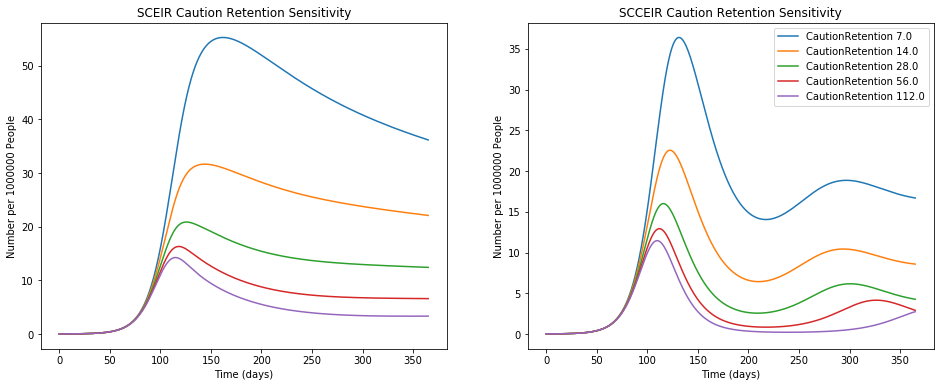

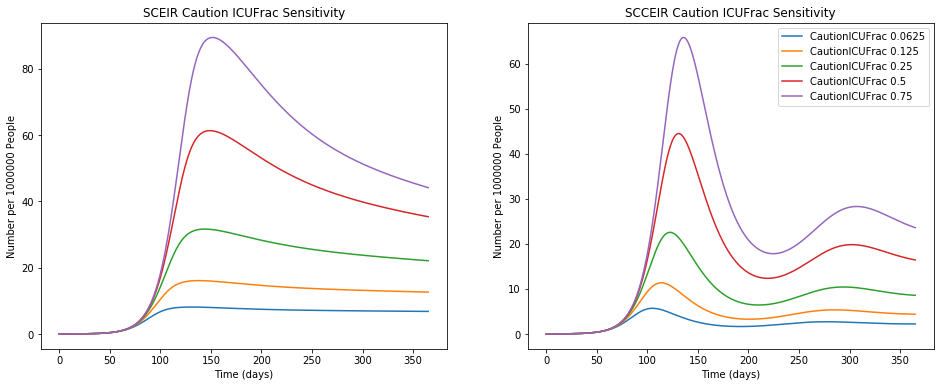

In [70]:
# caution standard parameters
CautionFactor= 0.3    # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 14. # Duration of cautionary state of susceptibles (4 weeks)
CautionICUFrac= 0.25  # Fraction of ICUs occupied leading to transition to caution @ 1/day 
ICUFrac= 0.001        # Fraction of ICUs relative to population size N

# Sensitivity scans
CautionFactors= [0.1,0.25,0.5,0.75,1.0]  # Fractional reduction of exposure rate for cautioned individuals
CautionRetentions= [7.,14.,28.,56.,112.] # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFracs= [0.0625,0.125,0.25,0.5,0.75] # Fraction of ICUs occupied leading to 90% of susceptibles in caution 

newplot = True
for i in range(5):
    c[0]=CautionFactors[i]
    c[1]=1./CautionRetention
    c[2]=1./(N*ICUFrac*CautionICUFrac)
    label_c = 'CautionFactor %s' % CautionFactors[i]
    plottitle = 'Caution Factor Sensitivity' 
    solns=solveplot(b,a,g,p,u,c,N,tmax,scale='linear',plottitle= plottitle,label=label_c,
              newplot = newplot,species='daily confirmed',models=['SCEIR','SCCEIR'])
    plt.legend()
    newplot = False


newplot = True
#for i in reversed(range(5)):
for i in range(5):
    c[0]=CautionFactor
    c[1]=1/CautionRetentions[i]
    c[2]=1./(N*ICUFrac*CautionICUFrac)
    label_c = 'CautionRetention %s'% CautionRetentions[i]
    plottitle = 'Caution Retention Sensitivity' 
    solns=solveplot(b,a,g,p,u,c,N,tmax,scale='linear',plottitle= plottitle,label=label_c,
              newplot = newplot,species='daily confirmed',models=['SCEIR','SCCEIR'])
    plt.legend()
    newplot = False

newplot = True    
for i in range(5):
    c[0]=CautionFactor
    c[1]=1/CautionRetention
    c[2]=1./(N*ICUFrac*CautionICUFracs[i])
    label_c = 'CautionICUFrac %s'% CautionICUFracs[i]
    plottitle = 'Caution ICUFrac Sensitivity' 
    solns=solveplot(b,a,g,p,u,c,N,tmax,scale='linear',plottitle= plottitle,label=label_c,
              newplot = newplot,species='daily confirmed',models=['SCEIR','SCCEIR'])
    plt.legend()
    newplot = False

### Interactive sliders for caution variables

Initialized to whatever is in the `c` array:

In [68]:
print('Currenly c = ',c)

Currenly c =  [0.3        0.07142857 0.004     ]


In [66]:
def isolveplot(c0,c1,c2):
    cc = [c0,c1,c2]
    solveplot(b,a,g,p,u,cc,N,tmax,scale='linear')

In [67]:
interact(isolveplot,c0=FloatSlider(min=0,max=1,step=0.01,value=c[0],description='c0',
                            style=style,layout=slider_layout,continuous_update=False),
                       c1=FloatSlider(min=0,max=.1,step=0.001,value=c[1],description='c1',
                            style=style,layout=slider_layout,continuous_update=False),
                       c2=FloatSlider(min=0,max=.01,step=0.0001,value=c[2],description='c2',
                            style=style,layout=slider_layout,continuous_update=False))

interactive(children=(FloatSlider(value=0.3, continuous_update=False, description='c0', layout=Layout(width='9…

<function __main__.isolveplot(c0, c1, c2)>

#### Cumulative corona cases

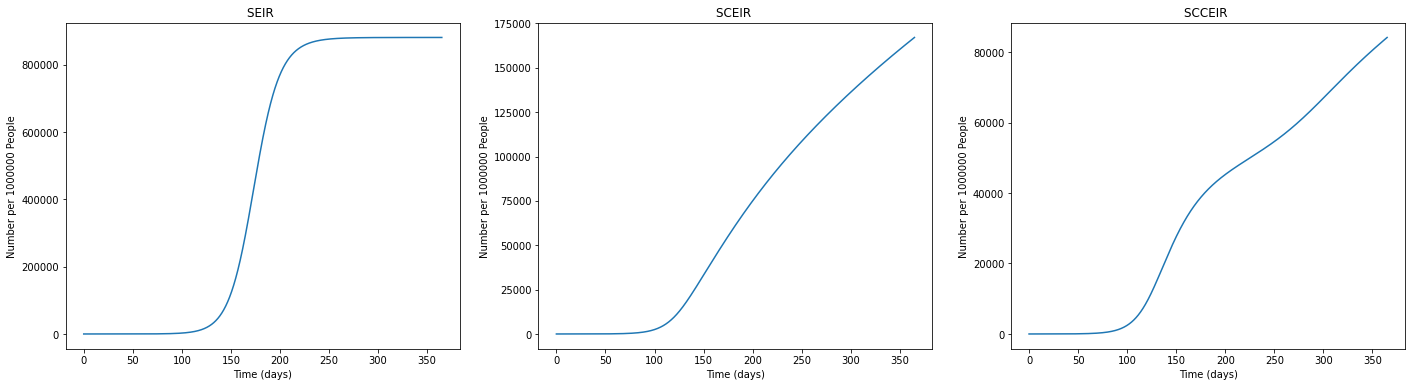

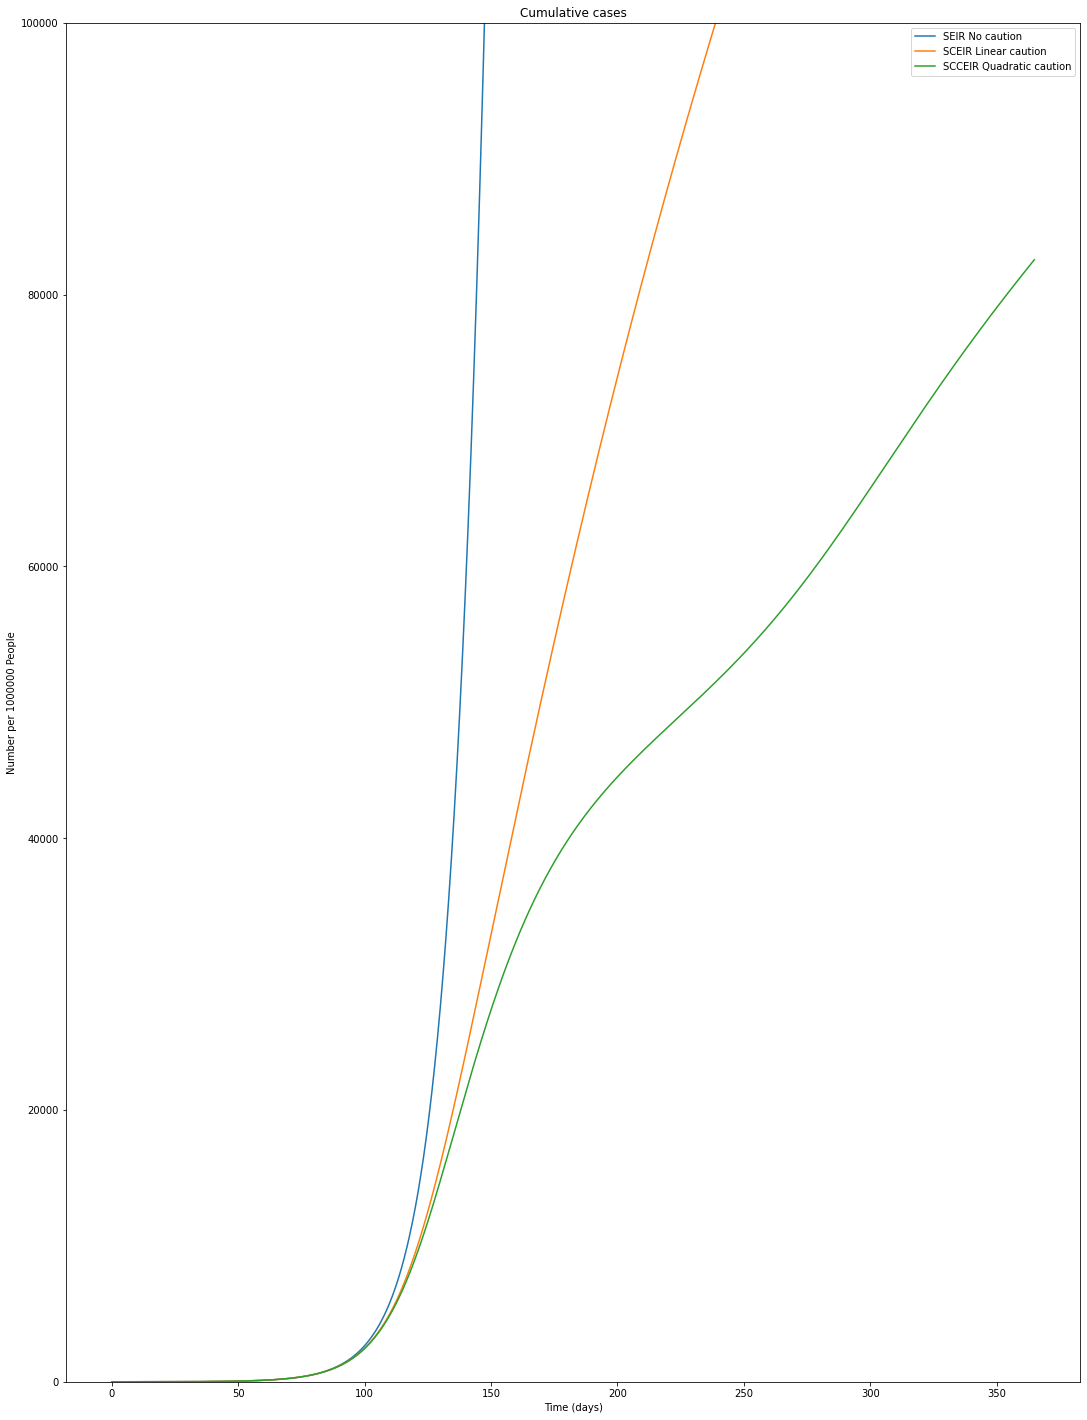

In [23]:
solns=solveplot(b,a,g,p,u,c,N,tmax,scale='linear',species='confirmed')
soln = solns[0]
solnc = solns[1]
solncc = solns[2]
plt.figure(figsize=(40,25))
plt.subplot(1,2,1)
sum0 = np.zeros(len(soln[:0]))
suma = np.zeros(len(soln[:0]))
sumb = np.zeros(len(soln[:0]))
sum0 = np.sum(soln[:,2:6],axis=1,keepdims=True)   # shape  (3650,1)
suma = np.sum(solnc[:,2:6],axis=1,keepdims=True)   # shape  (3650,1)
sumb = np.sum(solncc[:,2:6],axis=1) + solncc[:,9]  # shape  (3650,)
plt.plot(tvec,sum0)
plt.plot(tvec,suma)
plt.plot(tvec,sumb)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000000 People")
plt.legend(("SEIR No caution","SCEIR Linear caution","SCCEIR Quadratic caution"))
plt.ylim([0,100000])
plt.title('Cumulative cases')
print("")

## Dr. Alison's SEIR analysis

In [24]:
# get observed growth rate r (and doubling time) for a particular variable between selected time points
#(all infected classes eventually grow at same rate during early infection)

#Don't have a simple analytic formula for r for this model due to the complexity of the stages

def growth_rate(tvec,soln,t1,t2,i):
  i1=np.where(tvec==t1)[0][0]
  i2=np.where(tvec==t2)[0][0]
  r=(np.log(soln[i2,1])-np.log(soln[i1,1]))/(t2-t1)
  DoublingTime=np.log(2)/r

  return r, DoublingTime

In [25]:
(r,DoublingTime)=growth_rate(tvec,soln,10,20,1)
print("The epidemic growth rate is = {0:4.2f} per day and the doubling time {1:4.1f} days ".format(r,DoublingTime))

The epidemic growth rate is = 0.08 per day and the doubling time  8.9 days 


### Repeat of SEIR but with a social distancing measure that reduces transmission rate
This and subsequent sections currently unaltered from Dr. Alison Hill's notebook.

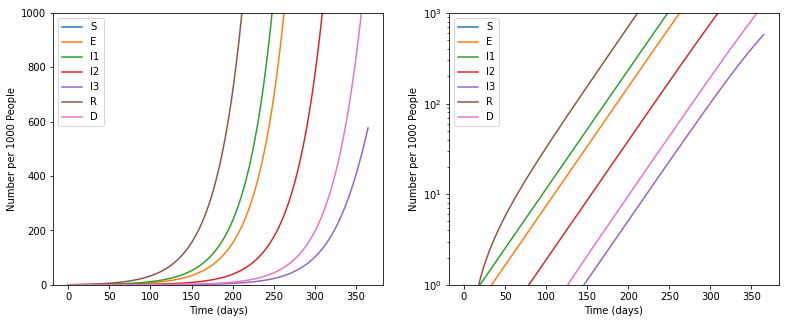

R0 under intervention =  1.5
The epidemic growth rate is = 0.03 per day and the doubling time 22.9 days 


In [26]:
bSlow=0.6*b
R0Slow=N*((bSlow[1]/(p[1]+g[1]))+(p[1]/(p[1]+g[1]))*(bSlow[2]/(p[2]+g[2])+ (p[2]/(p[2]+g[2]))*(bSlow[3]/(u+g[3]))))

solnSlow=odeint(seir,ic,tvec,args=(bSlow,a,g,p,u,N))
solnSlow=np.hstack((N-np.sum(solnSlow,axis=1,keepdims=True),solnSlow))

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,solnSlow)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("S","E","I1","I2","I3","R","D"))
plt.ylim([0,1000])

#Same plot but on log scale
plt.subplot(1,2,2)
plt.plot(tvec,solnSlow)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("S","E","I1","I2","I3","R","D"))
plt.ylim([1,1000])

(rSlow,DoublingTimeSlow)=growth_rate(tvec,solnSlow,30,40,1)

plt.show()
print("R0 under intervention = {0:4.1f}".format(R0Slow))
print("The epidemic growth rate is = {0:4.2f} per day and the doubling time {1:4.1f} days ".format(rSlow,DoublingTimeSlow))

#### Compare epidemic growth with and without intervention

Text(0.5, 1.0, 'All infectious cases')

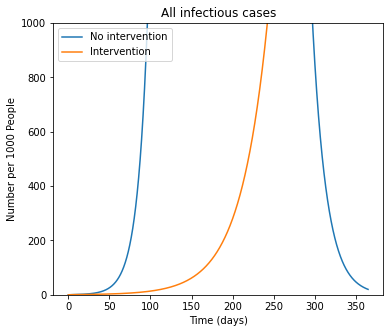

In [27]:
### All infectious cases (not exposed)

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,np.sum(soln[:,2:5],axis=1,keepdims=True))
plt.plot(tvec,np.sum(solnSlow[:,2:5],axis=1,keepdims=True))
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("No intervention","Intervention"))
plt.ylim([0,1000])
plt.title('All infectious cases')

## COVID19 Cases vs Hospital Capacity

Depending on the severity ($I_i$) stage of COVID-19 infection, patients need different level of medical care. 

Individuals in $I_1$ have "mild" infection, meaning they have cough/fever/other flu-like symptoms and may also have mild pneumonia. Mild pneumonia does not require hospitalization, although in many outbreak locations like China and South Korea all symptomatic patients are being hospitalized. This is likely to reduce spread and to monitor these patients in case they rapidly progress to worse outcome. However, it is a huge burden on the health care system.

Individuals in $I_2$ have "severe" infection, which is categorized medically as having any of the following: "dyspnea, respiratory frequency 30/min, blood oxygen saturation 93%, partial pressure of arterial oxygen to fraction of inspired oxygen ratio $<$300, lung infiltrates $>$50% within 24 to 48 hours". These individuals require hospitalization but can be treated on regular wards. They may require supplemental oxygen. 

Individuals in $I_3$ have "critical" infection, which is categorized as having any of the following: "respiratory failure, septic shock, and/or multiple organ dysfunction or failure".
They require ICU-level care, generally because they need mechanical ventilation. 

We consider different scenarios for care requirements. One variation between scenarios is whether we include hospitalization for all individuals or only those with severe or critical infection. Another is the care of critical patients. If ICUs are full, hospitals have protocols developed for pandemic influenza to provide mechanical ventilation outside regular ICU facility and staffing requirements. Compared to "conventional" ventilation protocols, there are "contingency" and "crisis" protocols that can be adopted to increase patient loads. These protocols involve increasing patient:staff ratios, using non-ICU beds, and involving non-critical care specialists in patient care. 



In [28]:
#Parameter sources: https://docs.google.com/spreadsheets/d/1zZKKnZ47lqfmUGYDQuWNnzKnh-IDMy15LBaRmrBcjqE

# All values are adjusted for increased occupancy due to flu season

AvailHospBeds=2.6*(1-0.66*1.1) #Available hospital beds per 1000 ppl in US based on total beds and occupancy
AvailICUBeds=0.26*(1-0.68*1.07) #Available ICU beds per 1000 ppl in US, based on total beds and occupancy. Only counts adult not neonatal/pediatric beds
ConvVentCap=0.062 #Estimated excess # of patients who could be ventilated in US (per 1000 ppl) using conventional protocols
ContVentCap=0.15 #Estimated excess # of patients who could be ventilated in US (per 1000 ppl) using contingency protocols
CrisisVentCap=0.42 #Estimated excess # of patients who could be ventilated in US (per 1000 ppl) using crisis protocols


### Assumptions 1
* Only severe or critical cases go to the hospital
* All critical cases require ICU care and mechanical ventilation


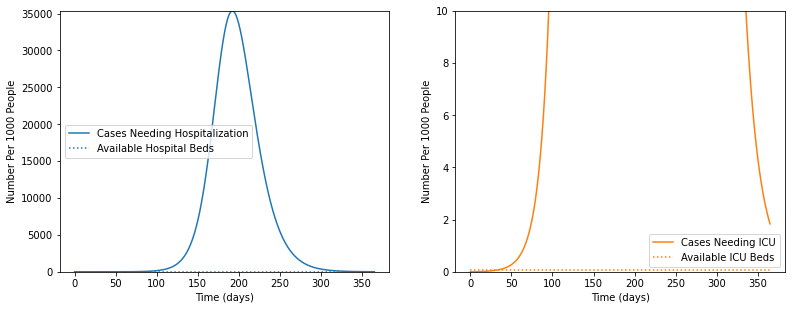

Hospital and ICU beds are filled by COVID19 patients after 32.1 and 33.1 days


In [29]:
NumHosp=soln[:,3]+soln[:,4]
NumICU=soln[:,4]

plt.figure(figsize=(13,4.8))
plt.subplot(1,2,1)
plt.plot(tvec,NumHosp)
plt.plot(np.array((0, tmax)),AvailHospBeds*np.ones(2),color='C0',linestyle=":")
plt.xlabel("Time (days)")
plt.ylabel("Number Per 1000 People")
plt.legend(("Cases Needing Hospitalization","Available Hospital Beds"))
ipeakHosp=np.argmax(NumHosp) #find peak
peakHosp=10*np.ceil(NumHosp[ipeakHosp]/10)#find time at peak
plt.ylim([0,peakHosp])

plt.subplot(1,2,2)
plt.plot(tvec,NumICU,color='C1')
plt.plot(np.array((0, tmax)),AvailICUBeds*np.ones(2),color='C1',linestyle=":")
plt.xlabel("Time (days)")
plt.ylabel("Number Per 1000 People")
plt.legend(("Cases Needing ICU","Available ICU Beds"))
ipeakICU=np.argmax(NumICU) #find peak
peakICU=10*np.ceil(NumICU[ipeakICU]/10)#find time at peak
plt.ylim([0,peakICU])
plt.ylim([0,10])

#Find time when hospitalized cases = capacity
icross=np.argmin(np.abs(NumHosp[0:ipeakHosp]-AvailHospBeds)) #find intersection before peak
TimeFillBeds=tvec[icross]

#Find time when ICU cases = capacity
icross=np.argmin(np.abs(NumICU[0:ipeakICU]-AvailICUBeds)) #find intersection before peak
TimeFillICU=tvec[icross]

plt.show()
print("Hospital and ICU beds are filled by COVID19 patients after {0:4.1f} and {1:4.1f} days".format(TimeFillBeds,TimeFillICU))

Note that we have not taken into account the limited capacity in the model itself. If hospitals are at capacity, then the death rate will increase, since individuals with severe and critical infection will often die without medical care. The transmission rate will probably also increase, since any informal home-care for these patients will likely not include the level of isolation/precautions used in a hospital.

#### Allow for mechanical ventilation outside of ICUs using contingency or crisis capacity

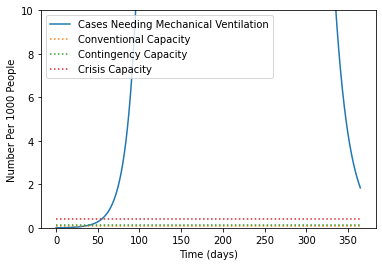

Capacity for mechanical ventilation is filled by COVID19 patients after 31.5 (conventional), 42.4 (contingency) and 55.4 (crisis) days


In [30]:
plt.plot(tvec,NumICU)
plt.plot(np.array((0, tmax)),ConvVentCap*np.ones(2),linestyle=":")
plt.plot(np.array((0, tmax)),ContVentCap*np.ones(2),linestyle=":")
plt.plot(np.array((0, tmax)),CrisisVentCap*np.ones(2),linestyle=":")
plt.xlabel("Time (days)")
plt.ylabel("Number Per 1000 People")
plt.legend(("Cases Needing Mechanical Ventilation","Conventional Capacity","Contingency Capacity","Crisis Capacity"))
plt.ylim([0,peakICU])
plt.ylim([0,10])

#Find time when ICU cases = conventional capacity
icrossConv=np.argmin(np.abs(NumICU[0:ipeakICU]-ConvVentCap)) #find intersection before peak
TimeConvCap=tvec[icrossConv]
icrossCont=np.argmin(np.abs(NumICU[0:ipeakICU]-ContVentCap)) #find intersection before peak
TimeContCap=tvec[icrossCont]
icrossCrisis=np.argmin(np.abs(NumICU[0:ipeakICU]-CrisisVentCap)) #find intersection before peak
TimeCrisisCap=tvec[icrossCrisis]

plt.show()
print("Capacity for mechanical ventilation is filled by COVID19 patients after {0:4.1f} (conventional), {1:4.1f} (contingency) and {2:4.1f} (crisis) days".format(TimeConvCap,TimeContCap,TimeCrisisCap))

Compare to the case with intervention

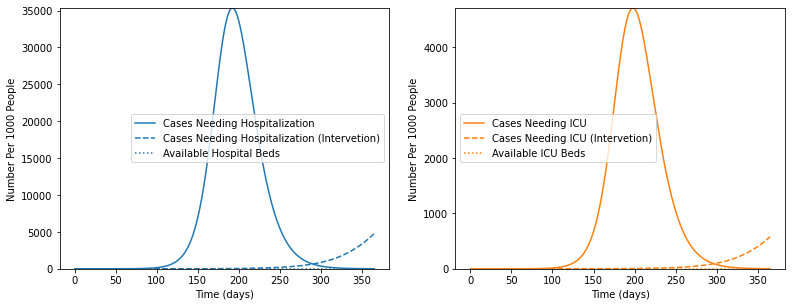

With intervention, hospital and ICU beds are filled by COVID19 patients after 63.7 and 58.7 days


In [31]:
NumHospSlow=solnSlow[:,3]+solnSlow[:,4]
NumICUSlow=solnSlow[:,4]

plt.figure(figsize=(13,4.8))
plt.subplot(1,2,1)
plt.plot(tvec,NumHosp)
plt.plot(tvec,NumHospSlow,color='C0',linestyle="--")
plt.plot(np.array((0, tmax)),AvailHospBeds*np.ones(2),color='C0',linestyle=":")
plt.xlabel("Time (days)")
plt.ylabel("Number Per 1000 People")
plt.legend(("Cases Needing Hospitalization","Cases Needing Hospitalization (Intervetion)","Available Hospital Beds"))
plt.ylim([0,peakHosp])

plt.subplot(1,2,2)
plt.plot(tvec,NumICU,color='C1')
plt.plot(tvec,NumICUSlow,color='C1',linestyle="--")
plt.plot(np.array((0, tmax)),AvailICUBeds*np.ones(2),color='C1',linestyle=":")
plt.xlabel("Time (days)")
plt.ylabel("Number Per 1000 People")
plt.legend(("Cases Needing ICU","Cases Needing ICU (Intervetion)","Available ICU Beds"))
plt.ylim([0,peakICU])

#Find time when hospitalized cases = capacity
ipeakHospSlow=np.argmax(NumHospSlow) #find peak
icross=np.argmin(np.abs(NumHospSlow[0:ipeakHospSlow]-AvailHospBeds)) #find intersection before peak
TimeFillBedsSlow=tvec[icross]

#Find time when ICU cases = capacity
ipeakICUSlow=np.argmax(NumICUSlow) #find peak
icross=np.argmin(np.abs(NumICUSlow[0:ipeakICU]-AvailICUBeds)) #find intersection before peak
TimeFillICUSlow=tvec[icross]

plt.show()
print("With intervention, hospital and ICU beds are filled by COVID19 patients after {0:4.1f} and {1:4.1f} days".format(TimeFillBedsSlow,TimeFillICUSlow))

And for expanded mechanical ventilation capacity

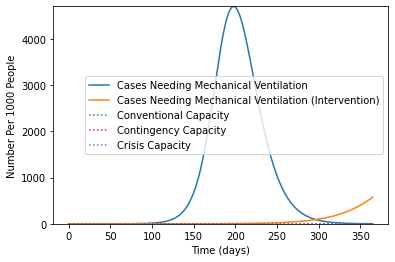

Capacity for mechanical ventilation is filled by COVID19 patients after 54.4 (conventional), 83.4 (contingency) and 117.4 (crisis) days


In [32]:
plt.plot(tvec,NumICU)
plt.plot(tvec,NumICUSlow)
plt.plot(np.array((0, tmax)),ConvVentCap*np.ones(2),linestyle=":")
plt.plot(np.array((0, tmax)),ContVentCap*np.ones(2),linestyle=":")
plt.plot(np.array((0, tmax)),CrisisVentCap*np.ones(2),linestyle=":")
plt.xlabel("Time (days)")
plt.ylabel("Number Per 1000 People")
plt.legend(("Cases Needing Mechanical Ventilation","Cases Needing Mechanical Ventilation (Intervention)","Conventional Capacity","Contingency Capacity","Crisis Capacity"))
plt.ylim([0,peakICU])

#Find time when ICU cases = conventional capacity (with intervention)
icrossConvSlow=np.argmin(np.abs(NumICUSlow[0:ipeakICUSlow]-ConvVentCap)) #find intersection before peak
TimeConvCapSlow=tvec[icrossConvSlow]
icrossContSlow=np.argmin(np.abs(NumICUSlow[0:ipeakICUSlow]-ContVentCap)) #find intersection before peak
TimeContCapSlow=tvec[icrossContSlow]
icrossCrisisSlow=np.argmin(np.abs(NumICUSlow[0:ipeakICUSlow]-CrisisVentCap)) #find intersection before peak
TimeCrisisCapSlow=tvec[icrossCrisisSlow]

plt.show()
print("Capacity for mechanical ventilation is filled by COVID19 patients after {0:4.1f} (conventional), {1:4.1f} (contingency) and {2:4.1f} (crisis) days".format(TimeConvCapSlow,TimeContCapSlow,TimeCrisisCapSlow))

Interpretation: While interventions that reduce infectiousness do "flatten the curve", cases are still WAY over hospital capacity. There is no way to get anywhere close to staying under hospital bed capacity or mechanical ventilation capacity without reducing $R_0<1$. 

### Assumptions 2
* All cases go to the hospital
* All critical cases require ICU care and mechanical ventilation

Note: No point running this scenario because it would be even more extreme than Assumption 1 (mild cases stayed home) and Assumption 1 already lead to rapid overlow of hospital resources


### Assumptions 3
* Only severe or critical cases go to the hospital
* All critical cases require ICU care and mechanical ventilation
* When hospital capacity is exceed, individual dies

Note: Could be used to simulate expected increases in death if capacity exceeded


## Alternative Models

To be continued, including
* Assuming ~30% of cases are asymptomatic (as seen on Diamond Princess) (This would lead to a re-interpretation of the reported rates of severe and critical infection, so the prevalence of these stages would decrease)
* A parallel instead of series model of disease course (because it is unclear if it is realistic that individuals who pass through the mild stage on the way to a severe state spend as long in the mild stage as individuals who never progress)
* Including pre-symptomatic transmission (for about last ~2 days of exposed period, as estimated in some studies)